# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters

In [3]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [4]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [5]:
params = vaep.nb.get_params(args, globals=globals())
params

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


{'folder_data': '',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'folder_experiment': 'runs/alzheimer_study',
 'model_key': 'RF',
 'target': 'AD',
 'sample_id_col': 'Sample ID',
 'cutoff_target': 0.5,
 'file_format': 'csv',
 'out_folder': 'diff_analysis',
 'fn_qc_samples': '',
 'baseline': 'PI',
 'template_pred': 'pred_real_na_{}.csv'}

In [6]:
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
args

root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

In [7]:
files_out = dict()

## Load target

In [8]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### Measured data

In [9]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_090  O94985                            21.480
Sample_034  P01593;P01594                     19.924
Sample_193  B4DYV8;Q8WZ75;Q8WZ75-2;Q8WZ75-3   14.855
Sample_074  Q13228;Q13228-4                   17.545
Sample_150  Q01995                            15.554
Name: intensity, dtype: float64

Get overlap between independent features and target

### Load ALD data or create

In [10]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [11]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load semi-supervised model imputations

In [12]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                                     
Sample_198  B4DHN5;E9PBU7;G5EA09;O00560;O00560-2                  13.673
Sample_004  A0A0B4J1Z1;C9JAB2;Q16629;Q16629-2;Q16629-3;Q16629-4   15.824
Sample_042  Q99538                                                15.950
Name: intensity, dtype: float64

In [13]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.625
            A0A075B6Q5                 12.870
            A0A075B6R2                 12.220
            A0A075B6S5                 12.145
            A0A087WSY4                 12.357
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.762
            Q9UI40;Q9UI40-2            13.981
            Q9UIW2                     12.220
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.847
            Q9UP79                     11.736
Name: intensity, Length: 46401, dtype: float64

## Model predictions
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
3. newly available feat only: the subset of features available from the
self supervised deep learning model which were newly retained using the
new approach

In [14]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.692,15.050,16.842,19.863,15.637,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.139,19.067,...,15.528,15.576,14.288,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.766,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.887,17.705,17.039,16.182,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.927,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.166,15.345,17.084,18.708,14.249,19.433,12.146,11.012
Sample_207,15.739,16.877,15.469,16.898,15.074,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [15]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.625,...,16.012,15.178,12.882,15.050,16.842,19.863,13.460,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.456,19.067,16.188,...,15.528,15.576,11.165,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.648,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.387,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.224,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.818,15.345,17.084,18.708,14.249,19.433,13.420,12.056
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [16]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification


In [17]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Best number of parameters by CV

In [18]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 203.25it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.40it/s]

100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.60it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.17it/s]

100%|██████████| 4/4 [00:00<00:00,  3.86it/s]

100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.45it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.52it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.63it/s]

100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.74it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.37it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.83it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.75it/s]

100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.84it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.65it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.32it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.35it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.34it/s]

100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.38it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.39it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.37it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.48it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.50it/s]

100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

100%|██████████| 8/8 [00:03<00:00,  2.57it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.87it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.09it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.59it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.32it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.29it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.23it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.27it/s]

100%|██████████| 9/9 [00:02<00:00,  2.79it/s]

100%|██████████| 9/9 [00:02<00:00,  3.24it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.41it/s]

 30%|███       | 3/10 [00:00<00:01,  3.70it/s]

 40%|████      | 4/10 [00:01<00:01,  3.05it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.67it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.69it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.73it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.78it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.52it/s]

100%|██████████| 10/10 [00:03<00:00,  2.36it/s]

100%|██████████| 10/10 [00:03<00:00,  2.72it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.20it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.17it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.05it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.91it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.98it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.06it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.15it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.09it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.12it/s]

100%|██████████| 11/11 [00:03<00:00,  3.16it/s]

100%|██████████| 11/11 [00:03<00:00,  3.14it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.40it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.82it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.10it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.87it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.68it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.60it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.58it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.45it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.39it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.20it/s]

100%|██████████| 12/12 [00:04<00:00,  1.95it/s]

100%|██████████| 12/12 [00:04<00:00,  2.46it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.96it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.14it/s]

 31%|███       | 4/13 [00:01<00:02,  3.52it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.06it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.55it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.28it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.02it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.13it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.23it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.16it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.40it/s]

100%|██████████| 13/13 [00:05<00:00,  2.58it/s]

100%|██████████| 13/13 [00:05<00:00,  2.57it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.56it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.66it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.52it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.19it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.05it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.71it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.80it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.98it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.10it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.23it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.31it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.44it/s]

100%|██████████| 14/14 [00:04<00:00,  3.51it/s]

100%|██████████| 14/14 [00:04<00:00,  3.27it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.73it/s]

 20%|██        | 3/15 [00:00<00:03,  3.45it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.26it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.17it/s]

 40%|████      | 6/15 [00:01<00:02,  3.16it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.12it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.11it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.17it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.26it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.34it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.44it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.60it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.61it/s]

100%|██████████| 15/15 [00:04<00:00,  3.61it/s]

100%|██████████| 15/15 [00:04<00:00,  3.42it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.068 0.027          0.650 0.423       0.091   
2             0.005 0.005      0.058 0.023          0.616 0.145       0.451   
3             0.007 0.005      0.069 0.031          0.804 0.082       0.732   
4             0.004 0.002      0.050 0.014          0.793 0.081       0.772   
5             0.004 0.001      0.045 0.010          0.800 0.089       0.802   
6             0.005 0.004      0.049 0.011          0.800 0.091       0.806   
7             0.004 0.002      0.053 0.018          0.813 0.087       0.812   
8             0.005 0.004      0.056 0.018          0.808 0.088       0.804   
9             0.005 0.003      0.061 0.021          0.856 0.080       0.820   
10            0.004 0.000      0.050 0.008          0.854 0.086       0.819   
11            0.008 0.007      0.081 0.034          0.850 0.073       0.824   
12            0.007 0.006      0.084 0.039          0.845 0.077       0.828   
13            0.004 0.001      0.047 0.010          0.841 0.075       0.819   
14            0.005 0.003      0.054 0.019          0.837 0.076       0.819   
15            0.005 0.003      0.056 0.020          0.842 0.075       0.818   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.153 0.127                  0.538 0.039        0.851   
2          0.112   0.510 0.100                  0.615 0.070        0.694   
3          0.094   0.762 0.071                  0.799 0.056        0.911   
4          0.111   0.777 0.075                  0.811 0.062        0.914   
5          0.115   0.795 0.077                  0.826 0.064        0.917   
6          0.114   0.797 0.078                  0.827 0.065        0.915   
7          0.101   0.808 0.074                  0.836 0.062        0.916   
8          0.099   0.802 0.072                  0.830 0.061        0.914   
9          0.088   0.833 0.065                  0.858 0.054        0.929   
10         0.091   0.832 0.067                  0.856 0.056        0.927   
11         0.089   0.834 0.063                  0.858 0.053        0.930   
12         0.096   0.833 0.072                  0.858 0.061        0.928   
13         0.095   0.826 0.069                  0.852 0.058        0.927   
14         0.095   0.824 0.067                  0.850 0.057        0.926   
15         0.093   0.827 0.069                  0.852 0.058        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.824 0.090        210.000 0.000  
2          0.087                  0.648 0.101        210.000 0.000  
3          0.042                  0.896 0.045        210.000 0.000  
4          0.042                  0.897 0.049        210.000 0.000  
5          0.042                  0.903 0.047        210.000 0.000  
6          0.043                  0.902 0.047        210.000 0.000  
7          0.044                  0.904 0.047        210.000 0.000  
8          0.044                  0.902 0.047        210.000 0.000  
9          0.042                  0.921 0.043        210.000 0.000  
10         0.044                  0.915 0.049        210.000 0.000  
11         0.045                  0.919 0.048        210.000 0.000  
12         0.045                  0.917 0.047        210.000 0.000  
13         0.045                  0.915 0.048        210.000 0.000  
14         0.045                  0.914 0.047        210.000 0.000  
15         0.043                  0.911 0.047 

In [19]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 367.50it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.65it/s]

100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.53it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.21it/s]

100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.59it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.74it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.58it/s]

100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.31it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.14it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.99it/s]

100%|██████████| 6/6 [00:02<00:00,  2.18it/s]

100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.21it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.56it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.26it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.72it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.51it/s]

100%|██████████| 7/7 [00:02<00:00,  2.25it/s]

100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.70it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.11it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.40it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.83it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.75it/s]

100%|██████████| 8/8 [00:03<00:00,  1.70it/s]

100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.54it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.31it/s]

 44%|████▍     | 4/9 [00:01<00:02,  1.89it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.74it/s]

 67%|██████▋   | 6/9 [00:03<00:01,  1.76it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.93it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.11it/s]

100%|██████████| 9/9 [00:04<00:00,  2.15it/s]

100%|██████████| 9/9 [00:04<00:00,  2.07it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.61it/s]

 30%|███       | 3/10 [00:00<00:01,  3.73it/s]

 40%|████      | 4/10 [00:01<00:01,  3.43it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.73it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.30it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.08it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.08it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.19it/s]

100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.65it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.96it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.45it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.35it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.47it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.11it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.97it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.82it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.89it/s]

100%|██████████| 11/11 [00:05<00:00,  1.99it/s]

100%|██████████| 11/11 [00:05<00:00,  2.17it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  2.92it/s]

 25%|██▌       | 3/12 [00:01<00:04,  2.21it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.08it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.94it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.01it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.06it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.06it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.09it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.03it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.10it/s]

100%|██████████| 12/12 [00:05<00:00,  2.24it/s]

100%|██████████| 12/12 [00:05<00:00,  2.14it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.24it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.37it/s]

 31%|███       | 4/13 [00:01<00:03,  2.32it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.14it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.10it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.29it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.34it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.35it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.40it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.45it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.49it/s]

100%|██████████| 13/13 [00:05<00:00,  2.53it/s]

100%|██████████| 13/13 [00:05<00:00,  2.40it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.05it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.56it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.08it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.87it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.58it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.60it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.43it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.44it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.51it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.14it/s]

 86%|████████▌ | 12/14 [00:04<00:01,  1.95it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.89it/s]

100%|██████████| 14/14 [00:06<00:00,  1.87it/s]

100%|██████████| 14/14 [00:06<00:00,  2.32it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.17it/s]

 20%|██        | 3/15 [00:00<00:03,  3.54it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.06it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.57it/s]

 40%|████      | 6/15 [00:02<00:03,  2.32it/s]

 47%|████▋     | 7/15 [00:02<00:04,  1.98it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.86it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.76it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.78it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.95it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.04it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.14it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.22it/s]

100%|██████████| 15/15 [00:06<00:00,  2.25it/s]

100%|██████████| 15/15 [00:06<00:00,  2.22it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.071 0.024          0.000 0.000       0.000   
2             0.005 0.004      0.065 0.027          0.741 0.133       0.528   
3             0.006 0.006      0.076 0.032          0.748 0.109       0.531   
4             0.006 0.004      0.061 0.018          0.757 0.096       0.557   
5             0.006 0.005      0.077 0.031          0.707 0.078       0.622   
6             0.008 0.008      0.076 0.032          0.715 0.084       0.622   
7             0.007 0.005      0.070 0.025          0.708 0.084       0.619   
8             0.004 0.003      0.052 0.029          0.727 0.089       0.663   
9             0.004 0.003      0.050 0.021          0.778 0.092       0.731   
10            0.006 0.005      0.072 0.034          0.786 0.090       0.739   
11            0.005 0.003      0.054 0.018          0.789 0.096       0.761   
12            0.005 0.003      0.053 0.013          0.801 0.098       0.757   
13            0.006 0.004      0.070 0.027          0.814 0.101       0.797   
14            0.006 0.005      0.062 0.024          0.820 0.098       0.792   
15            0.006 0.004      0.069 0.025          0.821 0.097       0.794   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.857   
2          0.113   0.608 0.098                  0.693 0.066        0.723   
3          0.119   0.611 0.094                  0.697 0.056        0.746   
4          0.120   0.632 0.087                  0.710 0.054        0.767   
5          0.122   0.655 0.083                  0.716 0.055        0.789   
6          0.120   0.657 0.079                  0.718 0.054        0.782   
7          0.127   0.652 0.085                  0.715 0.057        0.779   
8          0.119   0.687 0.085                  0.739 0.064        0.796   
9          0.112   0.748 0.079                  0.787 0.064        0.869   
10         0.115   0.756 0.081                  0.794 0.065        0.870   
11         0.107   0.768 0.075                  0.803 0.064        0.903   
12         0.113   0.772 0.079                  0.807 0.064        0.906   
13         0.108   0.799 0.077                  0.829 0.065        0.914   
14         0.108   0.801 0.080                  0.830 0.067        0.916   
15         0.108   0.801 0.078                  0.831 0.066        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.825 0.087        210.000 0.000  
2          0.081                  0.719 0.087        210.000 0.000  
3          0.070                  0.723 0.084        210.000 0.000  
4          0.070                  0.756 0.084        210.000 0.000  
5          0.062                  0.760 0.079        210.000 0.000  
6          0.064                  0.749 0.084        210.000 0.000  
7          0.067                  0.742 0.086        210.000 0.000  
8          0.069                  0.754 0.089        210.000 0.000  
9          0.059                  0.840 0.073        210.000 0.000  
10         0.058                  0.839 0.076        210.000 0.000  
11         0.051                  0.876 0.062        210.000 0.000  
12         0.047                  0.879 0.058        210.000 0.000  
13         0.045                  0.890 0.059        210.000 0.000  
14         0.045                  0.894 0.057        210.000 0.000  
15         0.045                  0.892 0.058 

In [20]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 936.65it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 19.16it/s]

100%|██████████| 2/2 [00:00<00:00, 18.47it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.86it/s]

100%|██████████| 3/3 [00:00<00:00, 16.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 13.61it/s]

100%|██████████| 4/4 [00:00<00:00, 10.81it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 13.68it/s]

100%|██████████| 5/5 [00:00<00:00, 10.64it/s]

100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.44it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.05it/s]

100%|██████████| 6/6 [00:00<00:00, 14.19it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.95it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 12.94it/s]

100%|██████████| 7/7 [00:00<00:00, 11.67it/s]

100%|██████████| 7/7 [00:00<00:00, 12.35it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 18.68it/s]

 50%|█████     | 4/8 [00:00<00:00, 13.76it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 12.72it/s]

100%|██████████| 8/8 [00:00<00:00, 11.61it/s]

100%|██████████| 8/8 [00:00<00:00, 12.36it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 15.17it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.81it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.71it/s]

100%|██████████| 9/9 [00:00<00:00, 11.36it/s]

100%|██████████| 9/9 [00:00<00:00, 11.97it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 19.92it/s]

 40%|████      | 4/10 [00:00<00:00, 12.59it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.18it/s]

 80%|████████  | 8/10 [00:00<00:00, 10.03it/s]

100%|██████████| 10/10 [00:00<00:00,  9.33it/s]

100%|██████████| 10/10 [00:00<00:00, 10.13it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 14.20it/s]

 45%|████▌     | 5/11 [00:00<00:00,  9.74it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  8.73it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.71it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  8.45it/s]

 91%|█████████ | 10/11 [00:01<00:00,  8.63it/s]

100%|██████████| 11/11 [00:01<00:00,  8.82it/s]

100%|██████████| 11/11 [00:01<00:00,  9.10it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.11it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.18it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.67it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.84it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.86it/s]

100%|██████████| 12/12 [00:00<00:00, 13.10it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.90it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.52it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.56it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.81it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.38it/s]

100%|██████████| 13/13 [00:01<00:00, 11.48it/s]

100%|██████████| 13/13 [00:01<00:00, 12.12it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.62it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.34it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.22it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 10.93it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.45it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.29it/s]

100%|██████████| 14/14 [00:01<00:00, 12.07it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.81it/s]

 20%|██        | 3/15 [00:00<00:01,  7.86it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.43it/s]

 40%|████      | 6/15 [00:00<00:01,  8.91it/s]

 47%|████▋     | 7/15 [00:00<00:00,  9.03it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.89it/s]

 60%|██████    | 9/15 [00:01<00:00,  9.09it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  9.88it/s]

 80%|████████  | 12/15 [00:01<00:00,  9.66it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.47it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.20it/s]

100%|██████████| 15/15 [00:01<00:00,  9.25it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.075 0.031          0.000 0.000       0.000   
2             0.005 0.004      0.057 0.020          0.644 0.164       0.328   
3             0.005 0.004      0.060 0.019          0.624 0.146       0.340   
4             0.005 0.004      0.072 0.029          0.638 0.143       0.348   
5             0.005 0.003      0.056 0.019          0.670 0.109       0.567   
6             0.007 0.006      0.086 0.038          0.664 0.090       0.592   
7             0.006 0.005      0.067 0.027          0.656 0.093       0.577   
8             0.005 0.003      0.065 0.026          0.658 0.099       0.583   
9             0.006 0.004      0.076 0.034          0.655 0.101       0.585   
10            0.004 0.002      0.047 0.004          0.656 0.097       0.589   
11            0.005 0.003      0.056 0.024          0.676 0.084       0.609   
12            0.006 0.005      0.066 0.026          0.702 0.089       0.647   
13            0.004 0.002      0.050 0.019          0.695 0.085       0.644   
14            0.008 0.006      0.084 0.029          0.690 0.086       0.653   
15            0.004 0.001      0.048 0.006          0.679 0.084       0.644   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.708   
2          0.089   0.426 0.097                  0.592 0.061        0.653   
3          0.105   0.430 0.107                  0.591 0.063        0.651   
4          0.102   0.442 0.104                  0.599 0.062        0.642   
5          0.119   0.608 0.101                  0.680 0.075        0.754   
6          0.112   0.622 0.093                  0.687 0.072        0.758   
7          0.110   0.609 0.092                  0.678 0.071        0.752   
8          0.112   0.614 0.095                  0.680 0.074        0.751   
9          0.118   0.613 0.100                  0.680 0.076        0.742   
10         0.127   0.616 0.105                  0.683 0.078        0.738   
11         0.122   0.635 0.090                  0.698 0.067        0.768   
12         0.116   0.668 0.087                  0.722 0.066        0.793   
13         0.124   0.662 0.090                  0.718 0.067        0.787   
14         0.127   0.663 0.087                  0.718 0.065        0.784   
15         0.128   0.653 0.084                  0.709 0.062        0.777   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.077                  0.670 0.088        210.000 0.000  
2          0.077                  0.611 0.084        210.000 0.000  
3          0.079                  0.604 0.084        210.000 0.000  
4          0.079                  0.606 0.084        210.000 0.000  
5          0.084                  0.707 0.092        210.000 0.000  
6          0.082                  0.712 0.088        210.000 0.000  
7          0.080                  0.705 0.086        210.000 0.000  
8          0.079                  0.703 0.084        210.000 0.000  
9          0.079                  0.702 0.082        210.000 0.000  
10         0.081                  0.689 0.085        210.000 0.000  
11         0.076                  0.726 0.087        210.000 0.000  
12         0.072                  0.743 0.083        210.000 0.000  
13         0.071                  0.735 0.087        210.000 0.000  
14         0.069                  0.733 0.086        210.000 0.000  
15         0.067                  0.727 0.086 

In [21]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,11,6,14
score_time,12,5,6
test_precision,9,15,12
test_recall,12,13,14
test_f1,11,15,12
test_balanced_accuracy,11,15,12
test_roc_auc,11,14,12
test_average_precision,9,14,12
n_observations,1,1,1


## Train, test split

In [22]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

In [23]:
njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


In [24]:
y_train.value_counts()

AD   
False   98
True    70
Name: count, dtype: int64

## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

In [25]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.38it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.57it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.72it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.52it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.46it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.45it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.39it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.05it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.93it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.99it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.03it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.13it/s]

100%|██████████| 14/14 [00:05<00:00,  2.26it/s]

100%|██████████| 14/14 [00:05<00:00,  2.33it/s]

In [26]:
# all(results_model_full.test.roc.tpr
#     ==
#     vaep.sklearn.Results.from_pickle(fname).test.roc.tpr)

In [27]:
splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.78it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.94it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.13it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.11it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.06it/s]

100%|██████████| 12/12 [00:00<00:00, 12.41it/s]

In [28]:
splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.01it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.90it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.46it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.19it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.02it/s]

 64%|██████▎   | 7/11 [00:03<00:01,  2.07it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.17it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.18it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.26it/s]

100%|██████████| 11/11 [00:04<00:00,  2.41it/s]

100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

### ROC-AUC

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


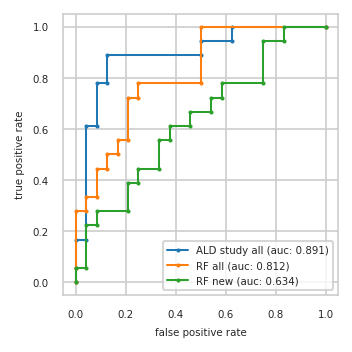

In [29]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [30]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.167  0.000 0.278  0.042 0.056
3          0.042 0.167  0.042 0.278  0.042 0.222
4          0.042 0.611  0.042 0.333  0.083 0.222
5          0.083 0.611  0.083 0.333  0.083 0.278
6          0.083 0.778  0.083 0.444  0.208 0.278
7          0.125 0.778  0.125 0.444  0.208 0.389
8          0.125 0.889  0.125 0.500  0.250 0.389
9          0.500 0.889  0.167 0.500  0.250 0.444
10         0.500 0.944  0.167 0.556  0.333 0.444
11         0.625 0.944  0.208 0.556  0.333 0.556
12         0.625 1.000  0.208 0.722  0.375 0.556
13         1.000 1.000  0.250 0.722  0.375 0.611
14           NaN   NaN  0.250 0.778  0.458 0.611
15           NaN   NaN  0.500 0.778  0.458 0.667
16           NaN   NaN  0.500 1.000  0.542 0.667
17           NaN   NaN  1.000 1.000  0.542 0.722
18           NaN   NaN    NaN   NaN  0.583 0.722
19           NaN   NaN    NaN   NaN  0.583 0.778
20           NaN   NaN    NaN   NaN  0.750 0.778
21           NaN   NaN    NaN   NaN  0.750 0.944
22           NaN   NaN    NaN   NaN  0.833 0.944
23           NaN   NaN    NaN   NaN  0.833 1.000
24           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected

In [31]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9P2E7;Q9P2E7-2,P01011,Q16799
2,P01597;P04432,P08670,P04040
3,P61981,Q9Y2T3;Q9Y2T3-3,E5RK69;E7EMC6;P08133;P08133-2
4,P04075,P61981,A0A075B7B8
5,P14174,P15151-2,Q96GD0
6,P00338;P00338-3,P04075,J3KSJ8;Q9UD71;Q9UD71-2
7,Q02818,P14174,P31150
8,Q9Y2T3;Q9Y2T3-3,P63104,A0A0J9YW36;Q9NZ72;Q9NZ72-2


### Precision-Recall plot

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


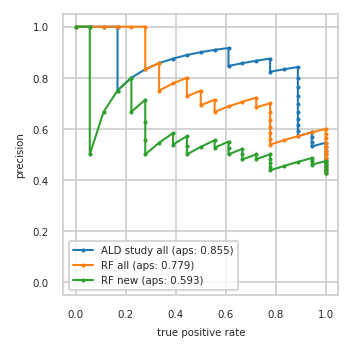

In [32]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [33]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.531 0.944     0.562 1.000     0.438 0.778
11         0.548 0.944     0.581 1.000     0.452 0.778
12         0.567 0.944     0.600 1.000     0.467 0.778
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.571 0.889     0.571 0.889     0.500 0.778
15         0.593 0.889     0.556 0.833     0.481 0.722
16         0.615 0.889     0.538 0.778     0.500 0.722
17         0.640 0.889     0.560 0.778     0.480 0.667
18         0.667 0.889     0.583 0.778     0.500 0.667
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.727 0.889     0.636 0.778     0.500 0.611
21         0.762 0.889     0.667 0.778     0.524 0.611
22         0.800 0.889     0.700 0.778     0.550 0.611
23         0.842 0.889     0.684 0.722     0.526 0.556
24         0.833 0.833     0.722 0.722     0.556 0.556
25         0.824 0.778     0.706 0.667     0.529 0.500
26         0.875 0.778     0.688 0.611     0.500 0.444
27         0.867 0.722     0.667 0.556     0.533 0.444
28         0.857 0.667     0.714 0.556     0.571 0.444
29         0.846 0.611     0.692 0.500     0.538 0.389
30         0.917 0.611     0.750 0.500     0.583 0.389
31         0.909 0.556     0.727 0.444     0.545 0.333
32         0.900 0.500     0.800 0.444     0.500 0.278
33         0.889 0.444     0.778 0.389     0.556 0.278
34         0.875 0.389     0.750 0.333     0.625 0.278
35         0.857 0.333     0.857 0.333     0.714 0.278
36         0.833 0.278     0.833 0.278     0.667 0.222
37         0.800 0.222     1.000 0.278     0.800 0.222
38         0.750 0.167     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


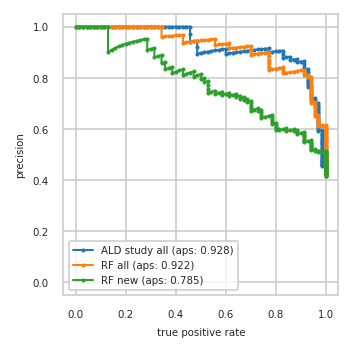

In [34]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


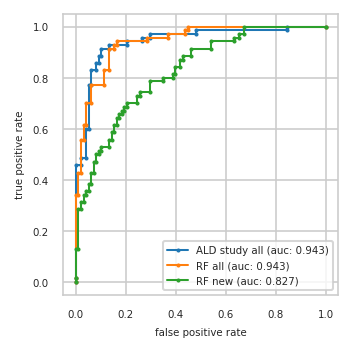

In [35]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Options:
- F1 results for test data for best cutoff on training data?
  (select best cutoff of training data, evaluate on test data)
- plot X_train PCA/UMAP, map X_test

In [36]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}